In [1]:
import os
import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt

from neuroginius.atlas import Atlas

from cogpred.utils.configuration import get_config
from cogpred.utils.naming import make_run_path
from cogpred.loading import TSFetcher, make_training_data
from cogpred.plotting import plot_ts
from cogpred.features import make_features, generate_single_sub

WIN_SIZE = 24
torch.manual_seed(1234)
np.random.seed(1234)

config = get_config()
conn_dir = config["connectivity_matrices"]

k=3
labels = pd.read_csv(f"data/cluster_{k}_labels.csv", index_col=0)
ATLAS = "schaefer200"

run_path = make_run_path(
    config["output_dir"],
    k=k,
    feat="series",
    experimental=True,
    atlas=ATLAS,
    winsize=WIN_SIZE,
    stamp=str(datetime.datetime.now())[:-7]
)
os.makedirs(run_path, exist_ok=True)

In [2]:
# TS from DMN only should be fun
tspath = Path("/georges/memento/BIDS/derivatives/schaeffer200_merged_phenotypes")
atlas = Atlas.from_name("schaefer200")
fetcher = TSFetcher(tspath)

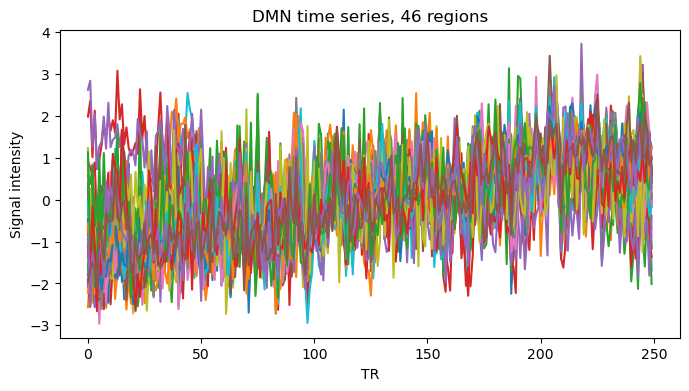

In [3]:
dmn_indexer = np.where(np.array(atlas.macro_labels) == "Default", True, False)

plot_ts(fetcher[100][:, dmn_indexer])
plt.title(f"DMN time series, {sum(dmn_indexer)} regions")
plt.show()

In [4]:
_, metadata = make_training_data(conn_dir, atlas.name, k)
rest_dataset = fetcher.rest_dataset

Dropping 8 subjects because of lacking MMMSE


In [5]:
metadata = pd.merge(
    rest_dataset,
    metadata,
    how="inner",
    on=["NUM_ID", "ses"],
    validate="many_to_one",
    suffixes=[None, "_"]
)

In [6]:
features = make_features(fetcher, metadata, dmn_indexer)

X, y, centre = [], [], []

for idx, X_i in enumerate(features):
    
    y_i = int(metadata.loc[idx, "cluster_label"])
    centre_i = metadata.loc[idx, "CEN_ANOM"]
    
    # Augment underepresented cases with smaller stride
    if y_i in {1, 2}:
        win_kwargs = dict(stride=2)
    else:
        win_kwargs = dict(stride=4)

    win_kwargs["window_size"] = WIN_SIZE
        
    windows_i, targets_i = generate_single_sub(X_i, y_i, **win_kwargs)
    
    X += windows_i
    y += targets_i
    centre += [centre_i] * len(targets_i)


X = torch.tensor(np.stack(X, axis=0)).transpose(1, 2)
y = torch.tensor(y)

In [7]:
import torch.functional as F
from torch import nn

n_channels = sum(dmn_indexer) # We want 1 channel per ROI
n_TR = X.shape[1]
num_pred_classes = k


In [8]:
from torch import functional as F
from torch import nn
import math

def initial_bump(C):
    """
    Hacky hardcoding
    """
    if C == 46:
        return 2 ** 8
    else:
        return C // 2 

def slow_increase(C):
    return math.ceil(C * 5/4)


def fast_increase(C):
    return C * 2


In [9]:
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit
from cogpred.supervised import macro_f1
from cogpred.models import WindowNetClassifier, BOLDCNN, default_channel_func

f1_cb = EpochScoring(macro_f1, lower_is_better=False, name="macro_f1")
early_stopping = EarlyStopping(
    monitor="macro_f1",
    lower_is_better=False,
    patience=5,
    load_best=True
)

counts = y.unique(return_counts=True)[1]

net = WindowNetClassifier(
    BOLDCNN,
    module__n_channels=n_channels,
    module__window_size=WIN_SIZE,
    max_epochs=20, # That seems too much
    criterion=nn.CrossEntropyLoss,
    criterion__weight=1/counts,
    optimizer=torch.optim.AdamW,
    iterator_train__shuffle=True,
    callbacks=[f1_cb, early_stopping],
    device=1,
    warm_start=False,
    batch_size=16,
    train_split=ValidSplit(cv=8)
)

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupShuffleSplit, cross_val_score

grid_params = dict(
    #module__num_conv_blocks=[1, 2, 3, 4],
    module__num_conv_blocks=[1, 2, 3, 4],
    #module__num_fc_blocks=[1, 2, 3],
    #module__conv_k=[3, 5, 7],
    module__channel_func=(
        default_channel_func,
        initial_bump,
        slow_increase,
        fast_increase
    ),
    optimizer__lr=np.geomspace(1e-5, 0.1, num=5),
    optimizer__weight_decay=np.geomspace(1e-5, 0.1, num=5)
)
# We can't have deep networks with higher pool_k
# We could try having another dict of shallow confs

gkf = GroupShuffleSplit(n_splits=5, random_state=1999)
cv = gkf.split(X, y, groups=centre)

search = RandomizedSearchCV(
    net,
    param_distributions=grid_params,
    n_iter=10,
    scoring=macro_f1,
    cv=cv,
    random_state=1999,
    verbose=1,
    n_jobs=8,
    error_score=np.nan, # There will be errors due to invalid architectures
    refit=True,
)
# Try initial bump, many convs, 1 fc

In [11]:
search.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
46 24
58 12
73 6
92 3
46 24
58 12
73 6
92 3
46 24
58 12
73 6
92 3
46 24
58 12
73 6
92 3
46 24
58 12
73 6
92 3
46 24
256 12
128 6
46 24
256 12
128 6
46 24
256 12
128 6
  epoch    macro_f1    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3555        1.0835       0.5417        0.9052  19.7341
  epoch    macro_f1    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3060        1.0695       0.4691        0.9647  18.5423
  epoch    macro_f1    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3130        1.0671       0.4629        0.9552  21.2935
  epoch    macro_f1    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
  

In [13]:
cv_results = pd.DataFrame(search.cv_results_).sort_values(by="rank_test_score")

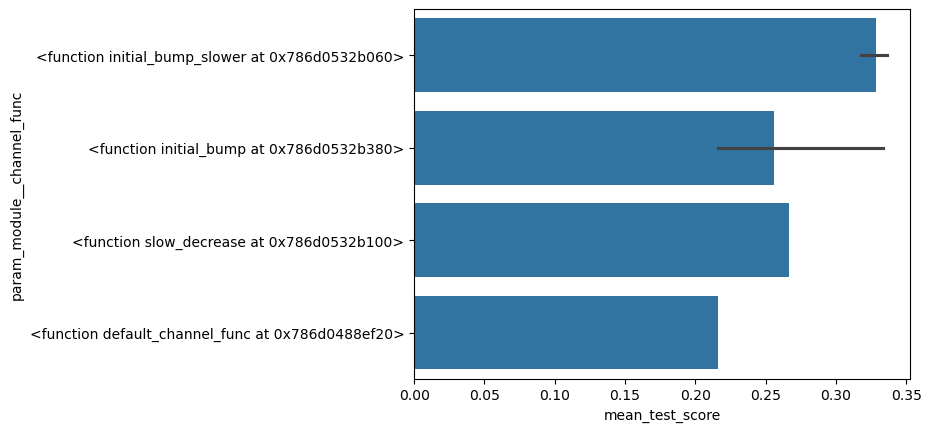

<Axes: xlabel='param_optimizer__lr', ylabel='mean_test_score'>

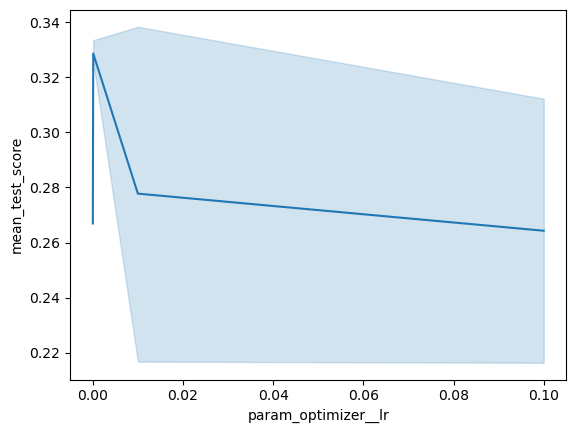

In [25]:
import seaborn as sns
sns.barplot(cv_results, y="param_module__channel_func", x="mean_test_score")
plt.show()
sns.lineplot(cv_results, x="param_optimizer__lr", y="mean_test_score")

In [15]:
from cogpred.models import count_parameters
count_parameters(search.best_estimator_.module)

TypeError: Module.named_parameters() missing 1 required positional argument: 'self'

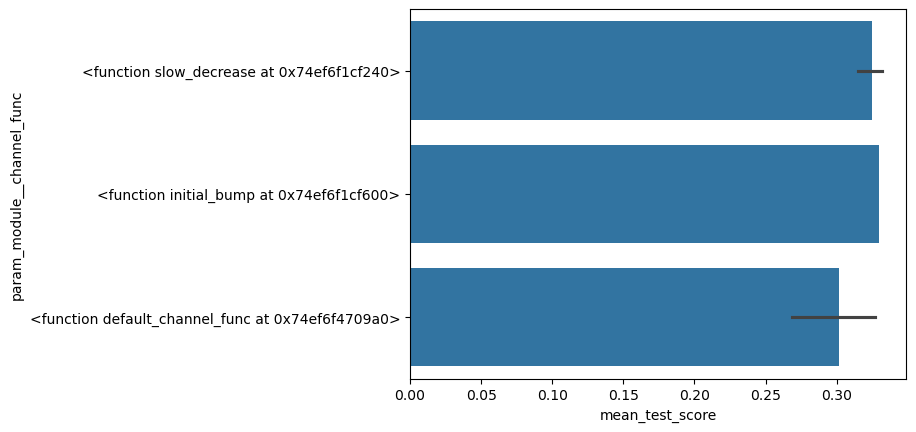

<Axes: xlabel='param_module__num_fc_blocks', ylabel='mean_test_score'>

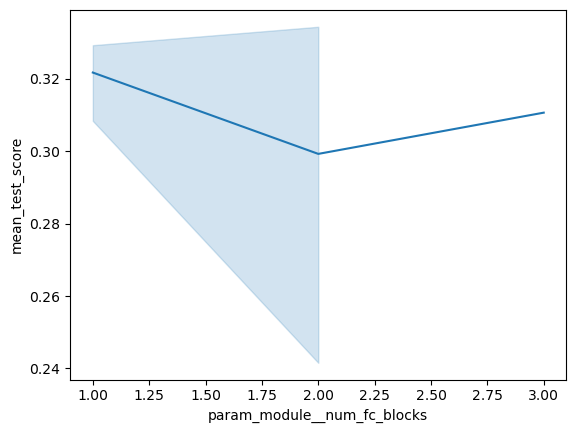

In [22]:
import seaborn as sns
sns.barplot(cv_results, y="param_module__channel_func", x="mean_test_score")
plt.show()
sns.lineplot(cv_results, x="param_module__num_fc_blocks", y="mean_test_score")

In [11]:
# TODO Tune stride and size of window
scores = cross_val_score(net, X, y, cv=cv, scoring=macro_f1)
scores

  epoch    macro_f1    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3126        1.0798       0.6388        0.8781  12.4868
      2      0.3326        0.8739       0.5501        0.9215  12.4880
      3      0.3296        0.6667       0.6151        1.0440  12.1675
      4      0.3016        0.5993       0.4075        1.1043  12.7484
      5      0.2629        0.5607       0.3494        1.2680  12.3082
      6      0.3064        0.5370       0.6426        1.1017  12.3772
Stopping since macro_f1 has not improved in the last 5 epochs.
Restoring best model from epoch 2.
  epoch    macro_f1    train_loss    valid_acc    valid_loss      dur
-------  ----------  ------------  -----------  ------------  -------
      1      0.3309        1.0725       0.5401        0.9413  11.1103
      2      0.3399        0.8814       0.4633        0.9981  12.5877
      3      0.3081        0.6630       0.6451        1.0835  

array([0.33986708, 0.31233814, 0.31148811, 0.33541713, 0.33257862,
       0.31795853, 0.33613766, 0.3347086 ])

In [25]:
import joblib
#joblib.dump(scores, run_path / "test_scores.joblib")
search.best_estimator_.save_params(f_params=run_path / "params.pkl")
metadata.to_csv(run_path / "metadata.csv")
 # We need best hyperparameters to re-instantiate the model
cv_results.to_csv(run_path / "cv_results.csv")